# Container Jupyter/all-spark-notebook
## Exampe 2.  A K-means computation in Spark
This is a simple demo of using spark to compute k-means where k = 4.   To make it easy to repeat the computation with different numbers of point and check the accuracy and performance, we create an artificial set of points in the plane where there are 4 clusters of "random" points.   

we first import the python spark package and several others we will need.   If pyspark does not load you may have the wrong kernel running.   On the data science vm, look for kernel "Spark-python".   

In [1]:
import sys
import time
import pyspark
from random import random

we are going to do some plotting, so let's set that up to.   also let's get the numpy library and call it np.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [3]:
import numpy as np

we first create the set of "n" points.  Later we will come back and try different values of n, but this is a good place to start.   We create n pairs of the form (0.0, 0.0)

In [4]:
n = 100000
nums = np.zeros((n,2))

In [5]:
nums.shape

(100000, 2)

Now we create four "random" clusters.  Each cluster is in the shape of a small circle of points. This is so that we can repeat the experiment and it will converge in the same way each time.   

In [6]:
for i in range(int(n/4)):
    x = random()*3.1415*2
    s =  0.6
    ranx = s*(2*random()-1)
    rany = s*(2*random()-1)
    nums[4*i] = np.array([1+ np.sin(x)*ranx, np.cos(x)*rany], dtype='f')
    x = random()*3.1415*2
    ranx = s*(2*random()-1)
    rany = s*(2*random()-1)
    nums[4*i+1] = np.array([np.sin(x)*ranx,1+ np.cos(x)*rany], dtype='f')
    x = random()*3.1415*2
    ranx = s*(2*random()-1)
    rany = s*(2*random()-1)
    nums[4*i+2] = np.array([np.sin(x)*ranx,-1+ np.cos(x)*rany], dtype='f')
    x = random()*3.1415*2
    ranx = s*(2*random()-1)
    rany = s*(2*random()-1)
    nums[4*i+3] = np.array([-1+ np.sin(x)*ranx, np.cos(x)*rany], dtype='f')
   

## the spark part starts here.
we begin by creating the local context.  On the data science VM using the spark-python kernel the spark local context aready exists and it is called "sc".

in other situations you need to specifically create one.  If the next command indicates that "sc" is not defined, then you need to create it by uncommenting the first line and running this step again.


if you want to connect to a cluster the instructions are here https://github.com/jupyter/docker-stacks/tree/master/all-spark-notebook.   

In [7]:
#sc = pyspark.SparkContext('local[*]')
sc

<SparkContext master=local[*] appName=pyspark-shell>

Next we create our Spark RDD with the data.   In Spark an RDD is a resilliant distribute dataset.  it is distrubted over a number of partitions.  If you have more than one core  or servers in your cluster, you can use this to share the work.   We will try various numbers of partitions.  Let's start with 4.   Later we can try 8 and 16 to see  how the performance changes.

In [8]:
numpartitions = 32
data = sc.parallelize(nums, numpartitions)

Let's view the data.   To do that we will use the RDD sample method to pull out a samle into a new RDD and apply the collect() function to return a regular array we can plot.

Text(0.5, 1.0, 'sample of unclusterd data. sample size = 112')

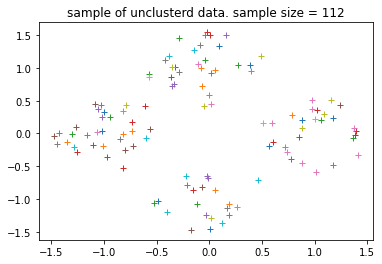

In [9]:
pts = data.sample(False,0.001,seed=22222).collect()
for y in pts:
    plt.plot(y[0],y[1],'+')
plt.title("sample of unclusterd data. sample size = "+str(len(pts)))

The following function takes a point p and an array of candidate cluster centers and returns the index of the nearest center.  this is how we will determine which cluster a point belongs to. 

In [10]:
def closestPoint(p, centers):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centers)):
        tempDist = np.sum((p - centers[i]) ** 2)
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return bestIndex

we will look for k clusters and we pick a set of "guesses" for the four starting points.   By starting this way, every time we run this it will be the same so that we can get consistent performance measurements.   The algorithm is very sensitive to the choice of starting points.  Bad choices will result in very bad selections of partitions.  (this is eally not a very good algorithm!)

In [11]:
K = 4
convergeDist = 0.01
kPoints = [[2., 0.], [0.0, 1.0], [-.1,0], [0,-2]]
ch = ['r+','g+','b+','c+','y+','k']

The algorithm is loop that runs until the centers are no longer moving.  This is not the best algorithm for k-means, but it illustrates Spark operations.
 we start with the data and use the map operation to create a new RDD of the form
 
     { (j, (p, 1)) where j is the index of the closest center to p for each p in data}
     
 we next recuce this so that we have the set
 
    { (j, ( sum(p), sum(1) ) where the sum is over the the number of tuples from closest that have key j}
    
 We can now find the centroid for all the points closest to kpoints[j]  by computing {sum(p)/sum(1)}.   This is an RDD of size K and we can collect it and use it as the kPoints for the next iteration.
 
This algorithm is very sensitive to the initial choice of the centroids kPoints.  A bad choice will produce bizzare clusters.  But the point here is to illustrate Spark using an iterative may reduce algorithm.
 


In [12]:
tempDist = 1.0
numiters = 0
start_time = time.time()
while tempDist > convergeDist:
    closest = data.map(
        lambda p: (closestPoint(p, kPoints), (p, 1)))
    pointStats = closest.reduceByKey(
        lambda x, y : (x[0] + y[0], x[1] + y[1]))
    newPoints = pointStats.map(
        lambda x : (x[0], x[1][0]/ x[1][1])).collect()
    tempDist = sum(np.sum((kPoints[x] - y) ** 2) for (x, y) in newPoints)
    for (x, y) in newPoints:
        kPoints[x] = y
    numiters = numiters+1
end_time = time.time()
print("time = %f"%(end_time-start_time))

time = 11.952050


we can now look at the final clusters.

Final centers: [array([ 9.99068464e-01, -2.97828106e-04]), array([0.00194068, 1.00001624]), array([-9.99333444e-01,  8.24903715e-04]), array([ 5.42270040e-05, -9.98906888e-01])]
number if iterations =3


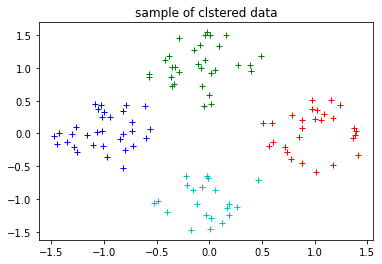

In [13]:
pts = data.map(
    lambda p:(closestPoint(p, kPoints), p)).sample(False,0.001,seed=22222).collect()

for (x,y)in pts:
    plt.plot(y[0],y[1],ch[x%4])
plt.title("sample of clstered data")
print("Final centers: %s"%str(kPoints))
print("number if iterations =%d"%numiters)


for fun, let's look at the performance for various values of n and k on the two machines.  To compare these results we can look at absolute execution times, but it is a bit more interesting to look at speed up as a function of the number of partitions of the SparkRDD.   

In [14]:
jet = [
[10000,
[[1  , 1.289854],
[2  , 0.929703],
[4  , 0.804337],
[8  , 0.725798],
[16 , 1.480762]]],
[100000,
[[1  , 10.309104],
[2  , 5.397808],
[4  , 3.580470],
[8  , 2.199382],
[16 , 2.574314]]],
[1000000,
[[1  , 97.472141],
[2  , 49.731367],
[4  , 27.401739],
[8  , 16.107580],
[16 , 16.601281]]]
]


In [15]:
mac = [[10000,
[[1  , 1.303219],
[2  , 0.882314],
[4  , 1.747807],
[8  , 1.871207],
[16 , 3.572536]]],
[100000,
[[1  , 8.646441],
[2  , 4.778752],
[4  , 5.553322],
[8  , 5.788275],
[16 , 8.081378]]],
[1000000,
[[1  , 80.778645],
[2  , 42.087406],
[4  , 41.951894],
[8  , 44.810061],
[16 , 43.249103]]]]

In [16]:
parts = [1,2,4,8,16]

In [17]:
from pylab import rcParams

In [18]:
rcParams['figure.figsize'] = 20, 5

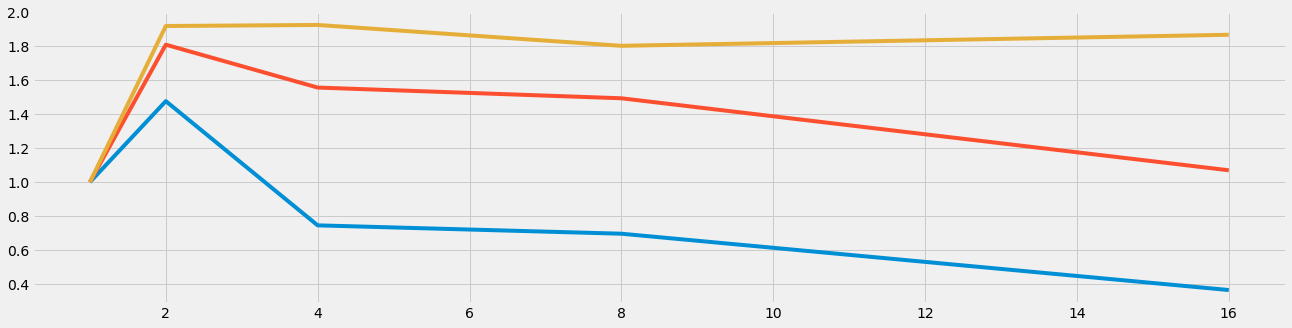

In [19]:
with plt.style.context('fivethirtyeight'):
    for i in range(3):
        minv = mac[i][1][0][1]
        macvals = [minv/x[1] for x in mac[i][1]]
        plt.plot(parts, macvals)

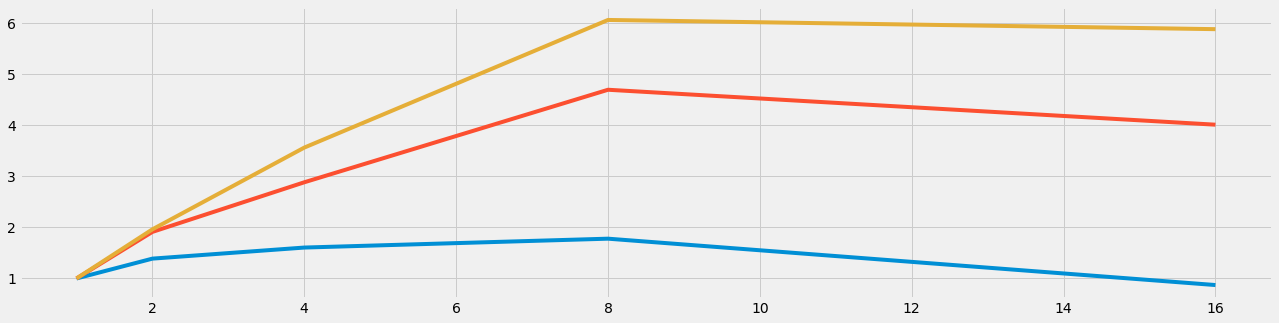

In [20]:
with plt.style.context('fivethirtyeight'):
    for i in range(3):
        minv = jet[i][1][0][1]
        jetvals = [minv/x[1] for x in jet[i][1]]
        plt.plot(parts, jetvals)

As you can see, the speedup for the 2-core mac is best with 2 partitions and the 8 cores of the JetStream server max out at  8 partitions.   What this says is that while more parallelism is available when the number of partitions is greater than the number of cores, the system cannot take advantage of it because the cores are already saturated with work.